## Stacking dengan Voting

Pada kasus ini kita akan menggunakan salah satu metode stacking yaitu voting untuk mengklasifikasikan pasien penderita diabetes dengan beberapa ciri. Pasien akan di klasifikasikan menjadi pasien menderita diabetes (1) dan tidak menderita diabetes (0). Pertama-tama, kita akan menggunakan beberapa algoritma klasifikasi secara terpisah, yaitu Naive Bayes, SVM Linier, dan SVM RBF. Setelah itu, kita akan menggabungkan performa dari 3 algoritma tersebut dengan menggunakan metode ensemble voting.

### Import Library

In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB # import Naive Bayes model Gaussian (asumsi data terdistribusi normal)
from sklearn.svm import SVC # import SVM classifier
from sklearn.ensemble import VotingClassifier # import model Voting
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

### Persiapan Data

In [2]:
# Load Data

dbt = pd.read_csv('/content/diabetes.csv')

dbt.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Cek nama kolom
dbt.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
# Cek kolom null
dbt.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
# Pada kasus ini, agak tidak masuk akal jika beberapa parameter bernilai 0
# sebagai contoh adalah nilai 'Glucose', 'BloodPlessure' ataupun 'Insulin'.
# Sekecil apapun nilainya, setiap manusia yang hidup pasti miliki nilai-nilai tersebut

# Kita akan manipulasi nilai yang 0 dengan melakukan 'imputasi' atau mengganti nilainya dengan nilai sintetis
# Pada kasus ini, kita akan menggunakan nilai mean

# Cek kolom neng nilai 0
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']
for column in feature_columns:
    print("============================================")
    print(f"{column} ==> Missing zeros : {len(dbt.loc[dbt[column] == 0])}")

Pregnancies ==> Missing zeros : 111
Glucose ==> Missing zeros : 5
BloodPressure ==> Missing zeros : 35
SkinThickness ==> Missing zeros : 227
Insulin ==> Missing zeros : 374
BMI ==> Missing zeros : 11
DiabetesPedigreeFunction ==> Missing zeros : 0
Age ==> Missing zeros : 0


In [6]:
# Impute nilai 0 dengan mean
from sklearn.impute import SimpleImputer

fill_values = SimpleImputer(missing_values=0, strategy="mean", copy=False)

dbt[feature_columns] = fill_values.fit_transform(dbt[feature_columns])

In [7]:
# Insulin null percentage

374 / 768 * 100/100

0.48697916666666674

In [8]:
# kolom insulin sebelumnya memiliki tingka null value yang sangat tinggi, meskipun kita isi itu tetap tidak berarti apa-apa (random guessing)
# tapi toleransi missing value itu subjektif, disini saya mencoba membuangnya saja

# dbt.drop("Insulin", axis=1, inplace=True)

In [9]:
# feature_columns.remove("Insulin")

### Split data training dan testing

In [10]:
X = dbt[feature_columns]
y = dbt.Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Training dengan GaussianNB

#### Standarisasi Fitur

In [11]:
# Karena asumsi Gaussian NB adalah data terdistribusi secara normal,
# maka kita perlu melakukan standarisasi

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# Standarisasi pada fitur di X_train dan X_test
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

#### Training dan Evaluasi

In [12]:
# Buat obyek GaussianNB
gnb_std = GaussianNB()

# Fit dengan data yang telah di standarisasi
gnb_std.fit(X_train_std, y_train)

# Prediksi dengan data test
y_pred_gnb = gnb_std.predict(X_test_std)

# Evaluasi akurasi testing data
acc_gnb = accuracy_score(y_test, y_pred_gnb)

# Print hasil evaluasi
print("Test set accuracy: {:.2f}".format(acc_gnb))
print(f"Test set accuracy: {acc_gnb}")

Test set accuracy: 0.72
Test set accuracy: 0.7229437229437229


### Training dengan SVM Linier

In [13]:
# Model SVM linier tanpa tunnning hyperparameter
svm_lin = SVC(kernel='linear')

# Fit ke model
svm_lin.fit(X_train_std, y_train)

# Prediksi
y_pred_svm_lin = svm_lin.predict(X_test_std)

# Evaluasi akurasi testing data
acc_svm_lin = accuracy_score(y_test, y_pred_svm_lin)

# Print hasil evaluasi
print("Test set accuracy: {:.2f}".format(acc_svm_lin))
print(f"Test set accuracy: {acc_svm_lin}")

Test set accuracy: 0.73
Test set accuracy: 0.7316017316017316


### Training dengan SVM RBF

In [14]:
# Model SVM RBF tanpa tunnning hyperparameter
svm_rbf = SVC(kernel='rbf')

# Fit ke model
svm_rbf.fit(X_train_std, y_train)

# Prediksi
y_pred_svm_rbf = svm_rbf.predict(X_test_std)

# Evaluasi akurasi testing data
acc_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)

# Print hasil evaluasi
print("Test set accuracy: {:.2f}".format(acc_svm_rbf))
print(f"Test set accuracy: {acc_svm_rbf}")

Test set accuracy: 0.74
Test set accuracy: 0.7359307359307359


### Training dengan Voting

In [15]:
# Definisikan algoritma yang akan digunakan untuk voting

clf1 = GaussianNB()
clf2 = SVC(kernel='linear')
clf3 = SVC(kernel='rbf', probability=True)

# model hard voting
voting = VotingClassifier(estimators=[('GaussianNB', clf1), ('SVM-LIN', clf2), ('SVM-RBF', clf3)], voting='hard')

# Fit model
voting.fit(X_train_std, y_train)

# Prediksi
y_pred_vt1 = voting.predict(X_test_std)

# Evaluasi akurasi testing data
acc_vt1 = accuracy_score(y_test, y_pred_vt1)

# Print hasil evaluasi
print('Voting Hard')
print("Test set accuracy: {:.2f}".format(acc_vt1))
print(f"Test set accuracy: {acc_vt1}")

Voting Hard
Test set accuracy: 0.74
Test set accuracy: 0.7359307359307359


## Tugas

Dengan menggunakan data yang sama, buatlan ensemble voting dengan algoritma
1. Logistic Regression
2. SVM kernel polynomial
3. Decission Tree

Anda boleh melakukan eksplorasi dengan melakukan tunning hyperparameter

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [17]:
log_reg = LogisticRegression(penalty='l2', fit_intercept=True, solver='lbfgs')

In [18]:
log_params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
}

svm_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
}

dtc_params = {
    'max_depth': [None, 3, 5, 7, 9],
    'min_samples_leaf': [1, 3, 5, 7, 9],
    'max_features': [None, 0.3, 0.5, 0.7, 0.9]
}

In [19]:
log_reg_tuning = GridSearchCV(LogisticRegression(), log_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
svm_tuning = GridSearchCV(SVC(kernel='poly', probability=True), svm_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
dtc_tuning = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [20]:
log_reg = LogisticRegression()
log_reg.fit(X_train_std, y_train)

print(log_reg.score(X_test_std, y_test))

0.7359307359307359


In [21]:
log_reg_tuning.fit(X_train_std, y_train)

print(log_reg_tuning.best_params_, log_reg_tuning.best_score_, log_reg_tuning.score(X_test_std, y_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'} 0.7820872274143302 0.7402597402597403


In [22]:
svm = SVC(kernel='poly', probability=True)
svm.fit(X_train_std, y_train)

print(svm.score(X_test_std, y_test))

0.7186147186147186


In [23]:
# karena proses train pada tuning svm cukup lama, saya putuskan tidak mentuningnya. Karena sebelumnya saya sudah menunggu kurang lebih 20 menit untuk cell ini

# svm_tuning.fit(X_train_std, y_train)

# print(svm_tuning.best_params_, svm_tuning.best_score_, svm_tuning.score(X_test_std, y_test))

In [24]:
dtc = DecisionTreeClassifier(random_state=123)
dtc.fit(X_train_std, y_train)

print(dtc.score(X_test_std, y_test))

0.7012987012987013


In [25]:
dtc_tuning.fit(X_train_std, y_train)

print(dtc_tuning.best_params_, dtc_tuning.best_score_, dtc_tuning.score(X_test_std, y_test))

Fitting 5 folds for each of 125 candidates, totalling 625 fits
{'max_depth': 3, 'max_features': 0.7, 'min_samples_leaf': 9} 0.7485808238144687 0.7359307359307359


In [26]:
voting = VotingClassifier([
    ('logreg', log_reg_tuning.best_estimator_),
    ('svm', SVC(kernel='poly', probability=True)),
    ('dtc', dtc_tuning.best_estimator_)
], voting='hard')

voting.fit(X_train_std, y_train)

print(voting.score(X_test_std, y_test))

0.7445887445887446


<Axes: >

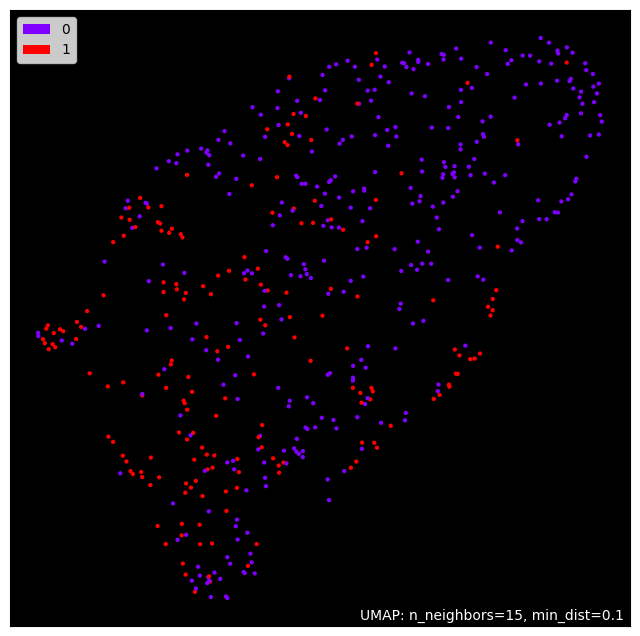

In [27]:
# berikut adalah visualisasi dari data train kita, cukup wajar jika model-model kita mendapatkan akurasi yang tidak cukup bagus

import umap
import umap.plot

mapper = umap.UMAP().fit(X_train_std)
umap.plot.points(mapper, labels=y_train, theme='fire')

In [28]:
from umap import UMAP
from plotly import express as px

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(X_train_std)
umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(y_train,name='label').astype(str)
print(type(x_umap))
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='label', labels={'color': 'number'}
)
fig.update_traces(marker_size=1.5)
fig.show()

<class 'numpy.ndarray'>


<h3> mari coba modelkan menggunakan stacking algoritma yang berbeda-beda

In [29]:
from pycaret.classification import *

In [30]:
clf1 = setup(data = dbt,
             target = 'Outcome',
             preprocess = False,
             )

,Description,Value
0,Session id,5483
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8


In [31]:
top5 = compare_models(n_select = 5,
                      exclude=['lightgbm','xgboost','dummy','svm','ridge','knn','dt','nb','qda']
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7656,0.8209,0.5614,0.7172,0.6253,0.4587,0.4689,0.6750
lda,Linear Discriminant Analysis,0.7656,0.8199,0.5667,0.7165,0.6287,0.4607,0.4704,0.1310
ada,Ada Boost Classifier,0.7523,0.7668,0.5865,0.6685,0.6193,0.4378,0.4437,0.2880
gbc,Gradient Boosting Classifier,0.7412,0.8006,0.5658,0.6560,0.6037,0.4136,0.4185,0.4950
rf,Random Forest Classifier,0.7318,0.7907,0.5383,0.6324,0.5774,0.3844,0.3888,0.4810
et,Extra Trees Classifier,0.7245,0.7904,0.5181,0.6256,0.5633,0.3662,0.3710,0.5740


Processing:   0%|          | 0/33 [00:00<?, ?it/s]

In [32]:
rf = create_model('rf')
lr = create_model('lr')
ada = create_model('ada')
lda = create_model('lda')
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.7459,0.5789,0.5500,0.5641,0.3180,0.3182
1,0.7593,0.8391,0.6316,0.6667,0.6486,0.4658,0.4661
2,0.7778,0.8368,0.6316,0.7059,0.6667,0.5008,0.5025
3,0.6852,0.7564,0.5263,0.5556,0.5405,0.3014,0.3016
4,0.7778,0.8226,0.6316,0.7059,0.6667,0.5008,0.5025
5,0.7778,0.8383,0.6842,0.6842,0.6842,0.5128,0.5128
6,0.6852,0.6481,0.4211,0.5714,0.4848,0.2656,0.2720
7,0.6604,0.7540,0.2778,0.5000,0.3571,0.1512,0.1633
8,0.7547,0.8349,0.5000,0.6923,0.5806,0.4136,0.4246


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.7729,0.5789,0.5500,0.5641,0.3180,0.3182
1,0.8333,0.9023,0.6842,0.8125,0.7429,0.6209,0.6259
2,0.7593,0.8632,0.5789,0.6875,0.6286,0.4524,0.4561
3,0.7222,0.7820,0.5789,0.6111,0.5946,0.3836,0.3839
4,0.8148,0.8286,0.6316,0.8000,0.7059,0.5735,0.5820
5,0.7222,0.7639,0.5263,0.6250,0.5714,0.3682,0.3711
6,0.7037,0.7323,0.3684,0.6364,0.4667,0.2812,0.3013
7,0.7736,0.7968,0.5556,0.7143,0.6250,0.4664,0.4740
8,0.7925,0.8683,0.5000,0.8182,0.6207,0.4890,0.5171


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7222,0.7504,0.7368,0.5833,0.6512,0.4255,0.4336
1,0.7593,0.7534,0.6316,0.6667,0.6486,0.4658,0.4661
2,0.7963,0.8496,0.6842,0.7222,0.7027,0.5479,0.5484
3,0.7222,0.6992,0.5263,0.6250,0.5714,0.3682,0.3711
4,0.7963,0.8113,0.6316,0.7500,0.6857,0.5367,0.5410
5,0.7593,0.7955,0.6842,0.6500,0.6667,0.4785,0.4788
6,0.7222,0.7233,0.5263,0.6250,0.5714,0.3682,0.3711
7,0.7547,0.7349,0.4444,0.7273,0.5517,0.3961,0.4189
8,0.7358,0.8079,0.5000,0.6429,0.5625,0.3775,0.3836


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.7759,0.5789,0.5500,0.5641,0.3180,0.3182
1,0.8333,0.9038,0.6842,0.8125,0.7429,0.6209,0.6259
2,0.7593,0.8571,0.5789,0.6875,0.6286,0.4524,0.4561
3,0.7222,0.7880,0.5789,0.6111,0.5946,0.3836,0.3839
4,0.8148,0.8316,0.6316,0.8000,0.7059,0.5735,0.5820
5,0.7037,0.7624,0.5263,0.5882,0.5556,0.3344,0.3355
6,0.7222,0.7293,0.4211,0.6667,0.5161,0.3350,0.3524
7,0.7736,0.7984,0.5556,0.7143,0.6250,0.4664,0.4740
8,0.7925,0.8619,0.5000,0.8182,0.6207,0.4890,0.5171


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6111,0.7278,0.5263,0.4545,0.4878,0.1771,0.1783
1,0.7778,0.8767,0.6842,0.6842,0.6842,0.5128,0.5128
2,0.8148,0.8857,0.6316,0.8000,0.7059,0.5735,0.5820
3,0.6481,0.7188,0.5263,0.5000,0.5128,0.2377,0.2379
4,0.8333,0.8992,0.6842,0.8125,0.7429,0.6209,0.6259
5,0.7963,0.8075,0.6842,0.7222,0.7027,0.5479,0.5484
6,0.6852,0.6586,0.4211,0.5714,0.4848,0.2656,0.2720
7,0.7358,0.7460,0.4444,0.6667,0.5333,0.3592,0.3736
8,0.7925,0.8571,0.6111,0.7333,0.6667,0.5178,0.5223


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
tuned_rf = tune_model(rf, optimize = 'Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.6940,0.4211,0.5714,0.4848,0.2656,0.2720
1,0.7778,0.7835,0.4737,0.8182,0.6000,0.4609,0.4939
2,0.8148,0.8165,0.5263,0.9091,0.6667,0.5507,0.5902
3,0.6852,0.6496,0.3158,0.6000,0.4138,0.2260,0.2477
4,0.7407,0.7120,0.3158,0.8571,0.4615,0.3357,0.4083
5,0.7963,0.7436,0.4737,0.9000,0.6207,0.4992,0.5472
6,0.7778,0.7030,0.4211,0.8889,0.5714,0.4462,0.5029
7,0.7736,0.7714,0.3333,1.0000,0.5000,0.3977,0.4982
8,0.7925,0.8032,0.4444,0.8889,0.5926,0.4734,0.5245


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [34]:
tuned_lr = tune_model(lr, optimize = 'Accuracy')
tuned_lda = tune_model(lda, optimize = 'Accuracy')
tuned_ada = tune_model(ada, optimize = 'Accuracy')
tuned_gbc = tune_model(gbc, optimize = 'Accuracy')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.7744,0.5789,0.5500,0.5641,0.3180,0.3182
1,0.8333,0.9038,0.6842,0.8125,0.7429,0.6209,0.6259
2,0.7593,0.8617,0.5789,0.6875,0.6286,0.4524,0.4561
3,0.7222,0.7865,0.5789,0.6111,0.5946,0.3836,0.3839
4,0.8148,0.8286,0.6316,0.8000,0.7059,0.5735,0.5820
5,0.7222,0.7624,0.5263,0.6250,0.5714,0.3682,0.3711
6,0.7037,0.7308,0.3684,0.6364,0.4667,0.2812,0.3013
7,0.7736,0.7937,0.5556,0.7143,0.6250,0.4664,0.4740
8,0.7925,0.8683,0.5000,0.8182,0.6207,0.4890,0.5171


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.7729,0.5789,0.5500,0.5641,0.3180,0.3182
1,0.8148,0.8977,0.6316,0.8000,0.7059,0.5735,0.5820
2,0.7593,0.8481,0.5789,0.6875,0.6286,0.4524,0.4561
3,0.7222,0.7820,0.5789,0.6111,0.5946,0.3836,0.3839
4,0.7963,0.8286,0.6316,0.7500,0.6857,0.5367,0.5410
5,0.7037,0.7549,0.5263,0.5882,0.5556,0.3344,0.3355
6,0.7222,0.7368,0.4211,0.6667,0.5161,0.3350,0.3524
7,0.7736,0.7968,0.5556,0.7143,0.6250,0.4664,0.4740
8,0.7925,0.8556,0.5000,0.8182,0.6207,0.4890,0.5171


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6481,0.7594,0.5263,0.5000,0.5128,0.2377,0.2379
1,0.7222,0.7714,0.4211,0.6667,0.5161,0.3350,0.3524
2,0.7963,0.8647,0.6316,0.7500,0.6857,0.5367,0.5410
3,0.7593,0.7782,0.5789,0.6875,0.6286,0.4524,0.4561
4,0.8519,0.8594,0.6842,0.8667,0.7647,0.6588,0.6686
5,0.7963,0.8331,0.6316,0.7500,0.6857,0.5367,0.5410
6,0.6852,0.7083,0.4211,0.5714,0.4848,0.2656,0.2720
7,0.7547,0.7492,0.5000,0.6923,0.5806,0.4136,0.4246
8,0.7547,0.8333,0.5000,0.6923,0.5806,0.4136,0.4246


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7173,0.6316,0.5217,0.5714,0.3027,0.3064
1,0.7778,0.8256,0.5263,0.7692,0.6250,0.4749,0.4921
2,0.7593,0.8301,0.6316,0.6667,0.6486,0.4658,0.4661
3,0.7037,0.7474,0.6316,0.5714,0.6000,0.3656,0.3668
4,0.7963,0.8226,0.6316,0.7500,0.6857,0.5367,0.5410
5,0.7222,0.8180,0.5789,0.6111,0.5946,0.3836,0.3839
6,0.6481,0.6406,0.2632,0.5000,0.3448,0.1349,0.1479
7,0.6981,0.7111,0.3333,0.6000,0.4286,0.2456,0.2651
8,0.8113,0.8397,0.5556,0.8333,0.6667,0.5423,0.5640


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [35]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7699,0.5789,0.5238,0.5500,0.2863,0.2872
1,0.8333,0.9053,0.6842,0.8125,0.7429,0.6209,0.6259
2,0.7593,0.8632,0.5789,0.6875,0.6286,0.4524,0.4561
3,0.7222,0.7865,0.5789,0.6111,0.5946,0.3836,0.3839
4,0.7963,0.8301,0.6316,0.7500,0.6857,0.5367,0.5410
5,0.7222,0.7549,0.5263,0.6250,0.5714,0.3682,0.3711
6,0.7037,0.7203,0.3684,0.6364,0.4667,0.2812,0.3013
7,0.7736,0.8016,0.5556,0.7143,0.6250,0.4664,0.4740
8,0.8113,0.8698,0.5556,0.8333,0.6667,0.5423,0.5640


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

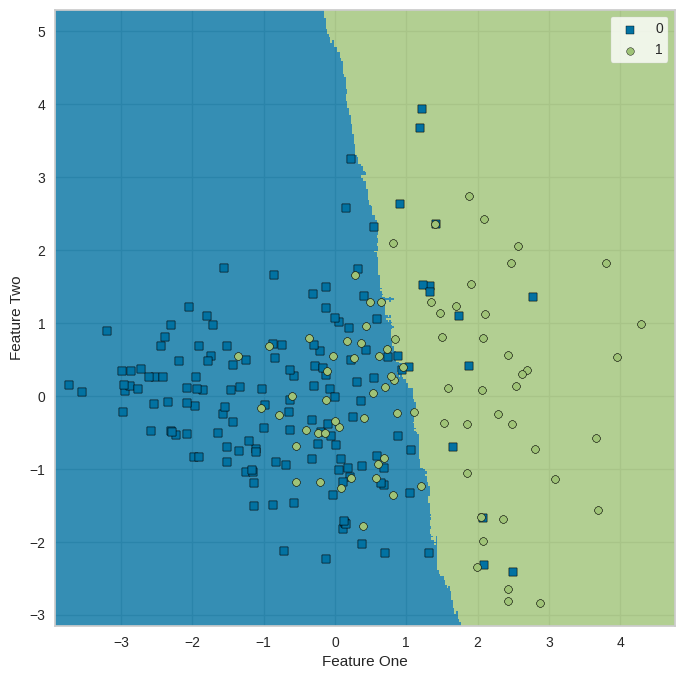

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plot_model(stack_model, plot='boundary')

In [37]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)

    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

In [38]:
pred = stack_model.predict(X_test_std)
pred_proba = stack_model.predict_proba(X_test_std)[:,1]
confusion_stack = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.6494, precision: 0.0000, recall: 0.0000,    F1: 0.0000, AUC:0.7037


Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

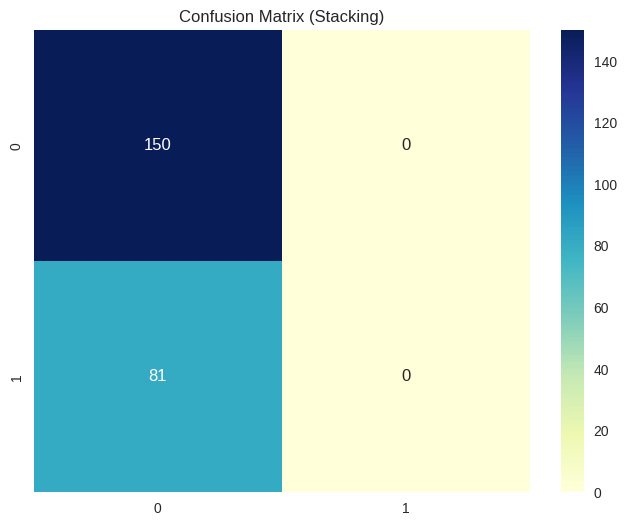

In [39]:
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_stack, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

In [40]:
# lakukan soft voting

blend_soft = blend_models(estimator_list = top5, optimize = 'Accuracy',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6481,0.7729,0.5789,0.5000,0.5366,0.2554,0.2572
1,0.7963,0.8842,0.6316,0.7500,0.6857,0.5367,0.5410
2,0.7593,0.8707,0.5789,0.6875,0.6286,0.4524,0.4561
3,0.7037,0.7789,0.5263,0.5882,0.5556,0.3344,0.3355
4,0.7593,0.8617,0.5789,0.6875,0.6286,0.4524,0.4561
5,0.7407,0.8180,0.5263,0.6667,0.5882,0.4028,0.4088
6,0.6852,0.6977,0.3158,0.6000,0.4138,0.2260,0.2477
7,0.7170,0.8000,0.4444,0.6154,0.5161,0.3234,0.3320
8,0.7925,0.8603,0.5556,0.7692,0.6452,0.5038,0.5172


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

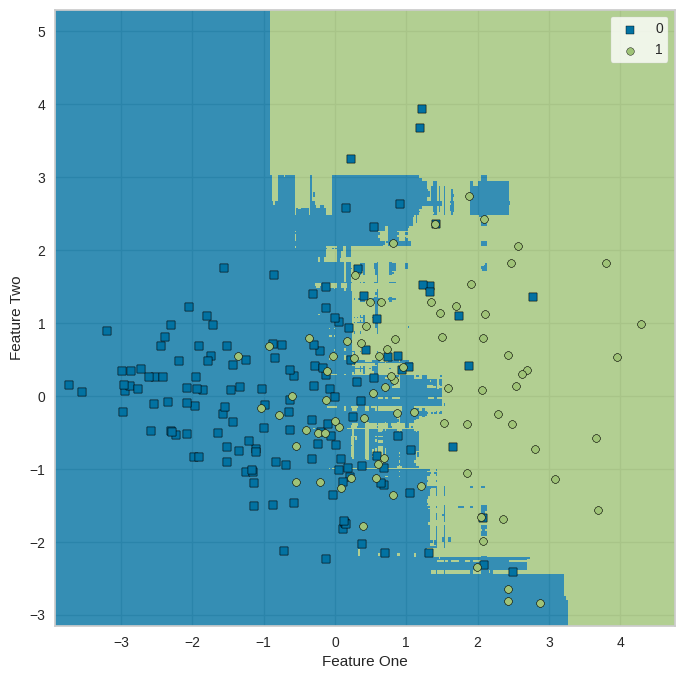

In [41]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot='boundary')

In [42]:
#prediction
pred = blend_soft.predict(X_test_std)
pred_proba = blend_soft.predict_proba(X_test_std)[:,1]
#Accuracy
confusion_soft = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.6494, precision: 0.0000, recall: 0.0000,    F1: 0.0000, AUC:0.6809


Text(0.5, 1.0, 'Confusion Matrix (Soft Blending)')

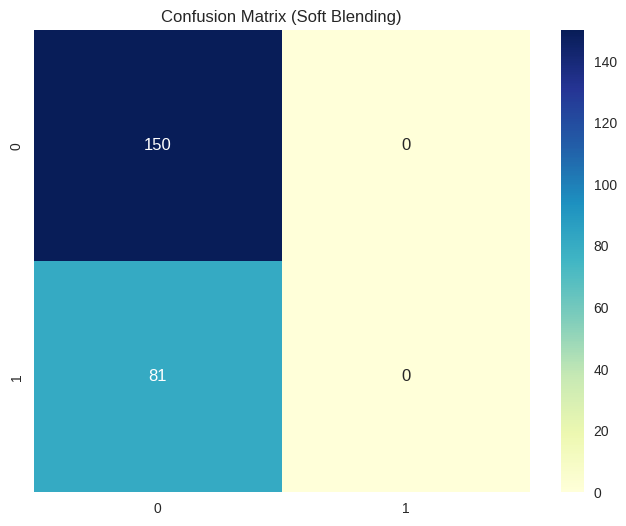

In [43]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_soft, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Soft Blending)')

In [44]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6481,0.0000,0.5789,0.5000,0.5366,0.2554,0.2572
1,0.7593,0.0000,0.6316,0.6667,0.6486,0.4658,0.4661
2,0.7593,0.0000,0.5789,0.6875,0.6286,0.4524,0.4561
3,0.7222,0.0000,0.5789,0.6111,0.5946,0.3836,0.3839
4,0.8333,0.0000,0.6842,0.8125,0.7429,0.6209,0.6259
5,0.7963,0.0000,0.7368,0.7000,0.7179,0.5587,0.5591
6,0.7037,0.0000,0.3684,0.6364,0.4667,0.2812,0.3013
7,0.7547,0.0000,0.5000,0.6923,0.5806,0.4136,0.4246
8,0.7547,0.0000,0.5000,0.6923,0.5806,0.4136,0.4246


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

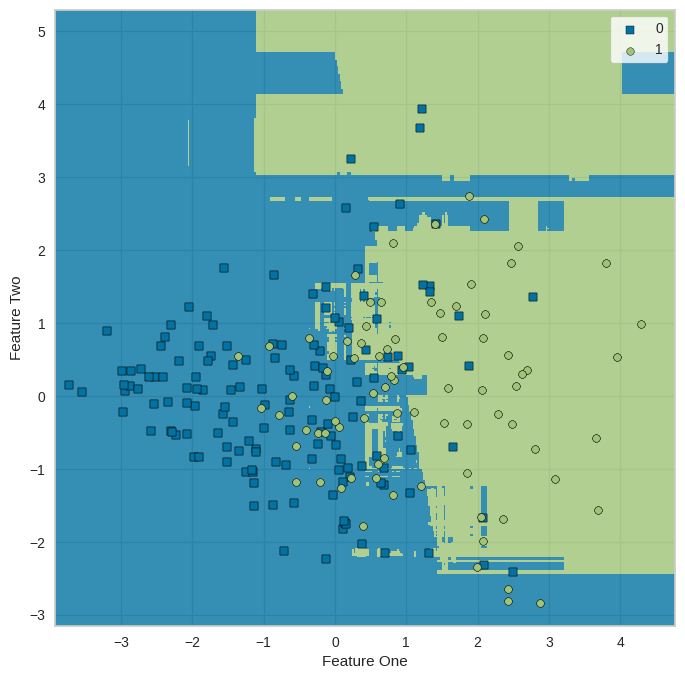

In [45]:
plt.figure(figsize=(8, 8))
plot_model(blend_hard, plot='boundary')

In [46]:
#prediction
pred = blend_hard.predict(X_test_std)
#Accuracy
confusion_hard = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred)
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.6494, precision: 0.0000, recall: 0.0000,F1: 0.0000


Text(0.5, 1.0, 'Confusion Matrix (Hard Blending)')

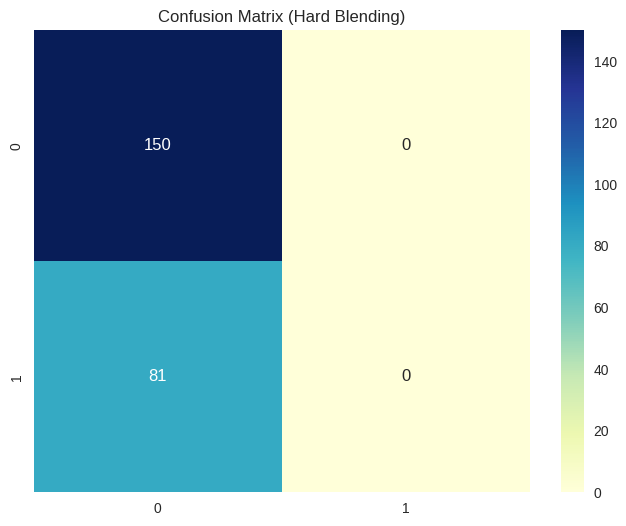

In [47]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Hard Blending)')

In [48]:
cali_model = calibrate_model(blend_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6481,0.7729,0.5789,0.5000,0.5366,0.2554,0.2572
1,0.7778,0.8917,0.5789,0.7333,0.6471,0.4882,0.4954
2,0.7593,0.8632,0.5789,0.6875,0.6286,0.4524,0.4561
3,0.7037,0.7895,0.5263,0.5882,0.5556,0.3344,0.3355
4,0.7593,0.8481,0.5789,0.6875,0.6286,0.4524,0.4561
5,0.7778,0.8180,0.5263,0.7692,0.6250,0.4749,0.4921
6,0.6852,0.7128,0.3158,0.6000,0.4138,0.2260,0.2477
7,0.7170,0.7968,0.4444,0.6154,0.5161,0.3234,0.3320
8,0.7736,0.8619,0.5000,0.7500,0.6000,0.4508,0.4688


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [49]:
final_model = finalize_model(cali_model)

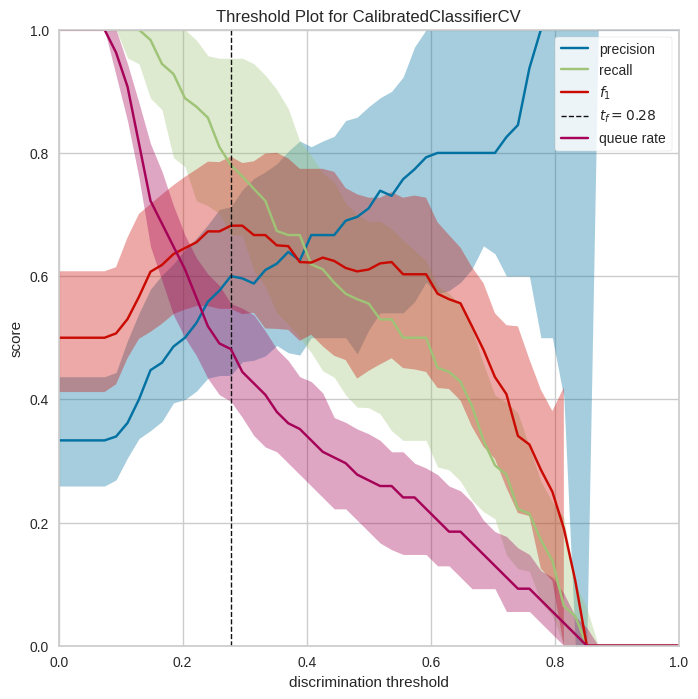

In [50]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='threshold')

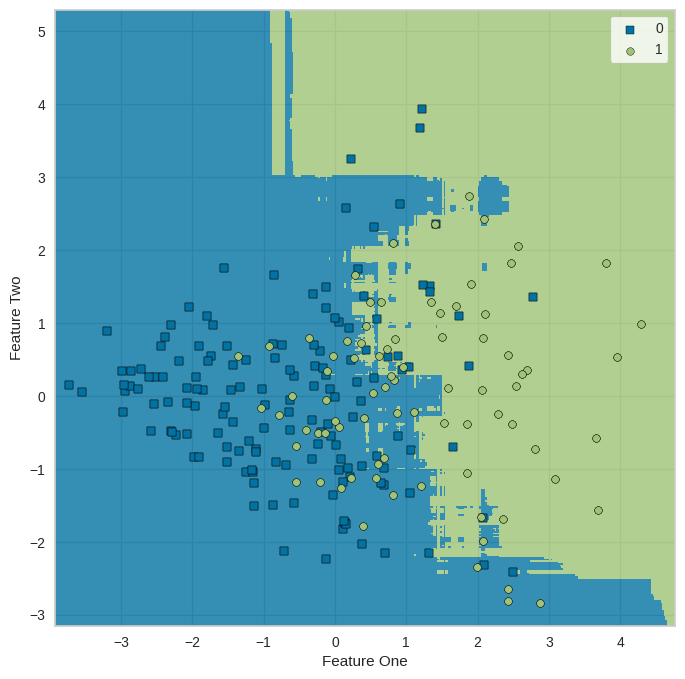

In [51]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='boundary')

In [52]:
#prediction
pred = final_model.predict(X_test_std)
#Accuracy
final_model = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred)
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.6494, precision: 0.0000, recall: 0.0000,F1: 0.0000


Text(0.5, 1.0, 'Confusion Matrix (final_model)')

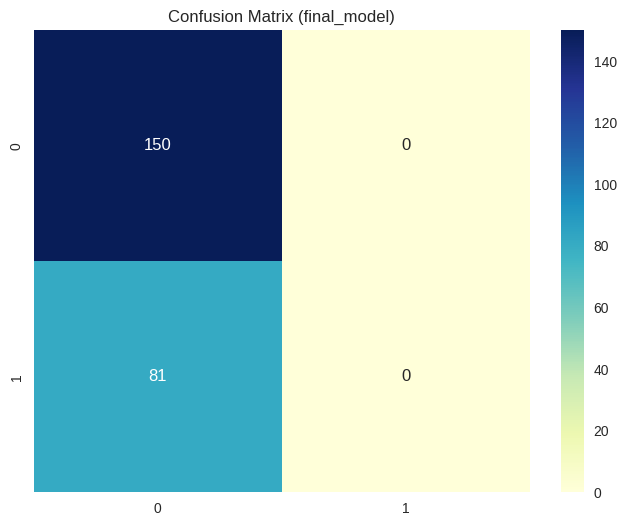

In [53]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')